# Exploration Node 3

In [1]:
# 필요 라이브러리 import
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib


## 사진 및 스티커 준비
### 얼굴 이미지

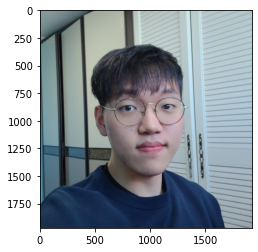

image shape:  (1969, 1920, 3)


In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/Exploration/EX3/image.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()
print('image shape: ', img_rgb.shape)

opencv는 BGR로 이미지가 처리가 되기 때문에 따로 RGB로 변환하여 img_rgb에 저장하였다. img_rgb는 최종 단계에서만 이용하고 중간 작업에서 이용할 출력용 img_show를 따로 만들었다. 

### 스티커 이미지

sticker shape:  (512, 512, 3)


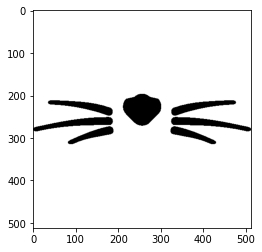

In [3]:
sticker_path = os.getenv('HOME')+'/aiffel/Exploration/EX3/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
plt.imshow(img_sticker)
print ('sticker shape: ', img_sticker.shape)

## 얼굴 검출 (Face Detection)

In [4]:
# Histogram of Orientated Gradients을 이용한 face detector 객체 선언 및 사진에 적용
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)   

rectangles[[(603, 692) (1401, 1491)]]


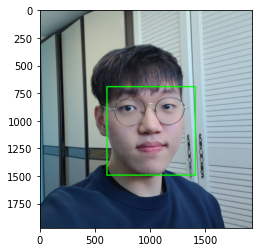

In [5]:
# Face Detection에서 얻은 얼굴의 bounding box 출력
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 10, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

얼굴에 맞추어 상자가 그려지는 것을 확인하여 얼굴 인식이 제대로 된 것을 알 수 있다. 

## 랜드마크 검출 (Landmark Detection)

In [6]:
# Landmark 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

Dlib의 face landmark 모델은 Exploration 노드 진행 중 다운 받은 것 그대로 이용하였다.

In [7]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


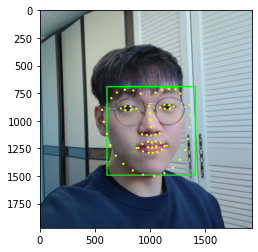

In [8]:
# landmark 사진에 출력
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 10, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

얼굴의 오른쪽의 점들이 살짝 얼굴을 벗어나는 느낌은 있지만, 아마 사진에 얼굴이 정면으로 나온 것이 아니기 때문에 나타는 현상 같다. 눈코입 같이 중요한 landmark들은 다 정확하게 검출했기 때문에 크게 문제 되지 않을 것이다. 

## 스티커 적용 위치 확인하기

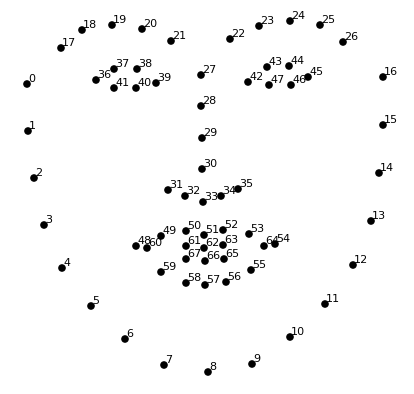 ![cat-whiskers.png](cat-whiskers.png)

스티커의 코의 위치가 스티커의 중앙과 거의 일치하기 때문에 사진의 코와 스티커의 중앙을 맞추면 된다. Landmark는 위와 같이 번호가 정해져있다. 스티커의 위치를 어디에 둘지를 정해야 하는데, 직접 실험 해본 결과 33번 landmark 위에 스티커의 중앙을 두면 너무 낮게 배치돼서 이상하고, 30으로 하면 너무 높다. 33번과 30번 landmark 딱 중간에 배치하는 것이 가장 자연스럽다. 다음의 x,y 계산은 이 점의 좌표를 구한 것이다.  
  
스티커의 크기도 고려해서 조정을 해야한다. 스티커도 원본이 정사각형인 이미지인데, 원본 크기 그대로 이 사진에 넣으면 좀 작다. 스티커의 너비는 수염의 양끝과 일치한다. 경험상 스티커는 크게 나오는 것이 더 자연스럽기 때문에 너비의 길이가 입의 3배가 되도록, landmark 54와 48을 이용하여 구했다. 

In [9]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[33][0]
    y = landmark[33][1]-(landmark[33][1] - landmark[30][1])//2
    w = h = 3 * (landmark[54][0] - landmark[48][0]) + 1#54 번째  landmark와 48 번째  landmark의 x좌표끼리 뺀 값 (입의 길이의 3배)
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(x,y) : (1004,1095)
(w,h) : (817,817)


(817, 817, 3)


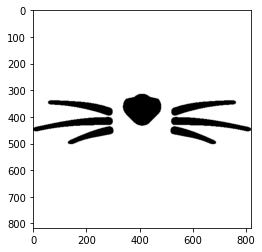

In [10]:
# 정한 높이와 너비에 맞게 스터커 크기 조정
img_sticker = cv2.resize(img_sticker, (w,h))#, interpolation = cv2.INTER_AREA)
print (img_sticker.shape)
plt.imshow(img_sticker)

## 스티커 적용하기

In [11]:
# 스티커의 좌표 조정 (왼쪽 위의 좌표에 맞춘다)
refined_x = x - w // 2
refined_y = y - h // 2
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (596,687)


In [12]:
# 스티커 위치가 사진 벗어날 경우 예외처리 

# 왼쪽과 위쪽으로 벗어나는 경우 (x 또는 y가 음수)
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0
    
# 오른쪽과 아래쪽으로 벗어나는 경우 (x, y가 원본 이미지의 크기보다 커질 때)
if refined_x > img_rgb.shape[1]: 
    img_sticker = img_sticker[:, :img_rgb.shape[1]]
    refined_x = img_rgb.shape[1]
if refined_y > img_rgb.shape[0]:
    img_sticker = img_sticker[:img_rgb.shape[0], :]
    refined_y = img_rgb.shape[0]

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (596,687)


In [13]:
# img_show 위에 스티커 이미지 추가하기
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)


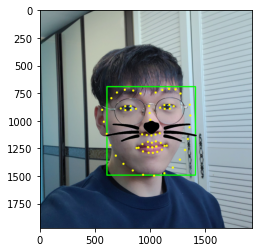

In [14]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 원본 사진 위에 덮어서 그리기

In [15]:
# 두 방법 비교하기 위해 원본의 카피를 새로 만든다
img_rgb_copy = img_rgb.copy()

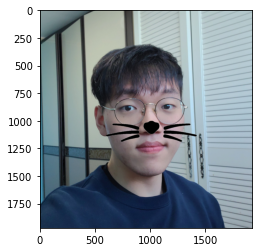

In [16]:
sticker_area = img_rgb[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_rgb[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(img_rgb)
plt.show()

### 스티커 뒤에 원본 사진 비치게 그리기

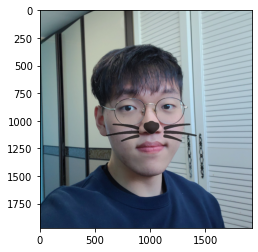

In [17]:
sticker_area = img_rgb_copy[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_rgb_copy[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,cv2.addWeighted(sticker_area, 0.3, img_sticker, 0.7, 0)).astype(np.uint8)
plt.imshow(img_rgb_copy)
plt.show()

## 문제점 찾아보기

위의 사진에서는 스티커앱이 정상적으로 작동하여 얼굴에 스티커를 잘 적용하였다. 하지만 이 사진은 얼굴을 정면에서 잘 찍은 예시이고, 다른 다양한 환경에서 찍은 사진들은 원하는대로 작동하지 않을 수도 있다. 이 앱에서 구현한 방법으로는 일어날 수 있는 문제점을 몇 가지 확인해보았다. 

### (1) 다른 각도로 찍었을 때

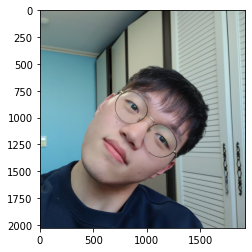

image shape:  (2029, 1920, 3)


In [18]:
new_image_path = os.getenv('HOME')+'/aiffel/Exploration/EX3/image_2.jpg'
new_img_bgr = cv2.imread(new_image_path)    # OpenCV로 이미지를 불러옵니다
new_img_show = new_img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
new_img_rgb = cv2.cvtColor(new_img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(new_img_rgb)
plt.show()
print('image shape: ', new_img_rgb.shape)

In [19]:
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(new_img_rgb, 1)

rectangles[[(514, 781) (1313, 1579)]]


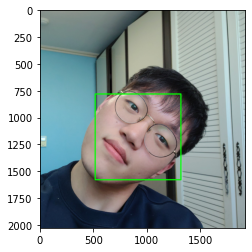

In [20]:
print(dlib_rects)  
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(new_img_show, (l,t), (r,b), (0,255,0), 10, lineType=cv2.LINE_AA)

new_img_show_rgb =  cv2.cvtColor(new_img_show, cv2.COLOR_BGR2RGB)
plt.imshow(new_img_show_rgb)
plt.show() 


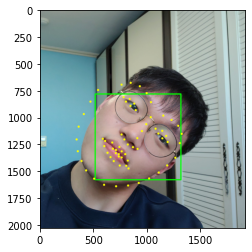

In [21]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(new_img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(new_img_show, point, 10, (0, 255, 255), -1)

new_img_show_rgb = cv2.cvtColor(new_img_show, cv2.COLOR_BGR2RGB)
plt.imshow(new_img_show_rgb)
plt.show()


In [22]:
print(landmark[30])
print(landmark[33])

(907, 1192)
(818, 1251)


In [23]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]-(landmark[30][0] - landmark[33][0])//2  #기울였기 때문에 x 좌표도 바뀌도록 설정하였다. 
    y = landmark[33][1]-(landmark[33][1] - landmark[30][1])//2
    w = h = 3 * (landmark[54][0] - landmark[48][0]) + 1#54 번째  landmark와 48 번째  landmark의 x좌표끼리 뺀 값 (입의 길이의 3배)
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(x,y) : (863,1222)
(w,h) : (721,721)


이번 사진은 기울여서 찍었기 때문에 x좌표도 반영돼서 바뀌도록 식을 추가하였다.

(721, 721, 3)


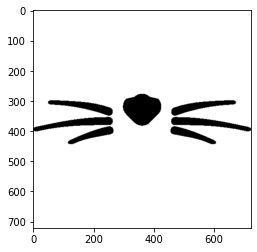

In [24]:
sticker_path = os.getenv('HOME')+'/aiffel/Exploration/EX3/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)

In [25]:
# 스티커의 좌표 조정
refined_x = x - w // 2
refined_y = y - h // 2
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (503,862)


In [26]:
# 스티커 위치가 사진 벗어날 경우 예외처리 
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (503,862)


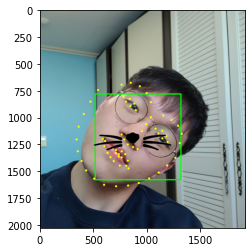

In [27]:
# img_show 위에 스티커 이미지 추가하기
sticker_area = new_img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
new_img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)


plt.imshow(cv2.cvtColor(new_img_show, cv2.COLOR_BGR2RGB))
plt.show()

#### 발견된 문제점: 

이전까지 짠 코드는 모두 사진이 정면을 바라본 얼굴일 것이라는 것을 전제로 하였다. 그렇기 때문에 얼굴 각도를 이렇게 기울여서 찍으면 스티커 앱이 제대로 작동하지 않는다. 문제가 일어나는 이유는 사진에 스티커를 추가하는 방법에서 이런 상황을 고려하지 않았기 때문이다. 스티커를 추가할 때 스티커를 원본 각도 그대로 추가하기 때문에 위와 같이 얼굴을 기울여도 스티커는 기울여지지 않고 그대로 추가된다.  
#### 해결책:  
이 문제를 해결하기 위해서 얼굴을 기울인 각도를 구해야 한다. 한 가지 방법으로 Landmark 중 얼굴의 중앙축을 알려줄 수 있는 두 점을 이어서 만들어지는 선을 이용하여 얼굴의 각도를 계산하고, 이에 맞게 스티커를 회전시켜서 배치하는 것이다. x,y의 위치는 정확하기 때문에 각도만 구하면 쉽게 해결할 수 있는 문제일 것 같다. 

### (2) 멀리서 촬영할 때

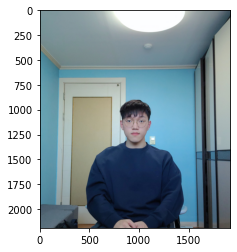

image shape:  (2190, 1920, 3)


In [28]:
new_image_path = os.getenv('HOME')+'/aiffel/Exploration/EX3/image_3.jpg'
new_img_bgr = cv2.imread(new_image_path)    # OpenCV로 이미지를 불러옵니다
new_img_show = new_img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
new_img_rgb = cv2.cvtColor(new_img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(new_img_rgb)
plt.show()
print('image shape: ', new_img_rgb.shape)

In [29]:
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(new_img_rgb, 1)

rectangles[[(825, 1033) (1092, 1301)]]


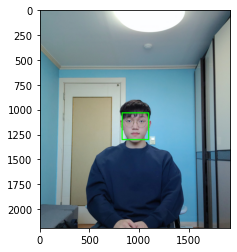

In [30]:
print(dlib_rects)  
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(new_img_show, (l,t), (r,b), (0,255,0), 10, lineType=cv2.LINE_AA)

new_img_show_rgb =  cv2.cvtColor(new_img_show, cv2.COLOR_BGR2RGB)
plt.imshow(new_img_show_rgb)
plt.show() 


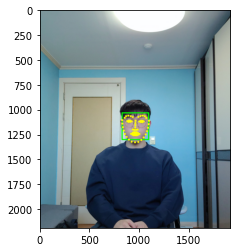

In [31]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(new_img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(new_img_show, point, 10, (0, 255, 255), -1)

new_img_show_rgb = cv2.cvtColor(new_img_show, cv2.COLOR_BGR2RGB)
plt.imshow(new_img_show_rgb)
plt.show()

In [32]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]-(landmark[30][0] - landmark[33][0])//2  #기울였기 때문에 x 좌표도 바뀌도록 설정하였다. 
    y = landmark[33][1]-(landmark[33][1] - landmark[30][1])//2
    w = h = 3 * (landmark[54][0] - landmark[48][0]) + 1#54 번째  landmark와 48 번째  landmark의 x좌표끼리 뺀 값 (입의 길이의 3배)
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(x,y) : (957,1193)
(w,h) : (256,256)


(256, 256, 3)


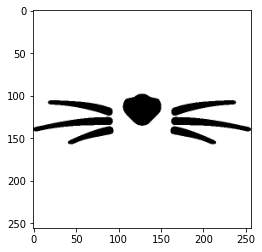

In [33]:
sticker_path = os.getenv('HOME')+'/aiffel/Exploration/EX3/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)

In [34]:
# 스티커의 좌표 조정
refined_x = x - w // 2
refined_y = y - h // 2
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (829,1065)


In [35]:
# 스티커 위치가 사진 벗어날 경우 예외처리 
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (829,1065)


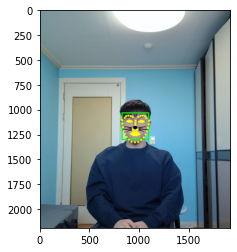

In [36]:
# img_show 위에 스티커 이미지 추가하기
sticker_area = new_img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
new_img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)


plt.imshow(cv2.cvtColor(new_img_show, cv2.COLOR_BGR2RGB))
plt.show()

멀리서 찍어서 분명 문제가 생길 것이라고 생각했는데, 의외로 정상적으로 작동하였다. 다른 사진으로 다시 진행했다.

### 두 번째 멀리서 찍은 사진

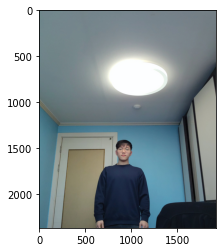

image shape:  (2369, 1920, 3)


In [37]:
new_image_path = os.getenv('HOME')+'/aiffel/Exploration/EX3/image_4.jpg'
new_img_bgr = cv2.imread(new_image_path)    # OpenCV로 이미지를 불러옵니다
new_img_show = new_img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
new_img_rgb = cv2.cvtColor(new_img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(new_img_rgb)
plt.show()
print('image shape: ', new_img_rgb.shape)

In [38]:
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(new_img_rgb, 1)

rectangles[[(838, 1474) (992, 1629)]]


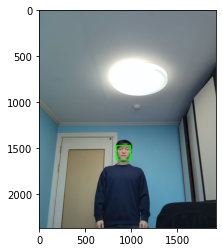

In [39]:
print(dlib_rects)  
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(new_img_show, (l,t), (r,b), (0,255,0), 10, lineType=cv2.LINE_AA)

new_img_show_rgb =  cv2.cvtColor(new_img_show, cv2.COLOR_BGR2RGB)
plt.imshow(new_img_show_rgb)
plt.show() 


이 사진도 너무 고화질이라 이렇게 멀리서 찍어도 인식이 되므로 사진을 해상도를 낮추어서 다시 시도하였다. 

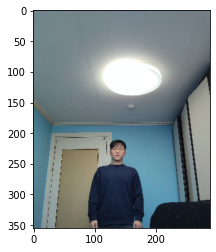

In [40]:
dst = cv2.resize(new_img_rgb, ((int(new_img_rgb.shape[1]*0.15)), int(new_img_rgb.shape[0]*0.15)))
plt.imshow(dst)
plt.show()

In [41]:
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(dst, 1)

rectangles[]


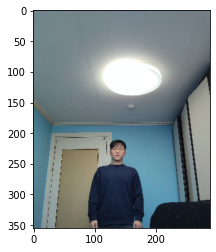

In [42]:
print(dlib_rects)  
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(dst, (l,t), (r,b), (0,255,0), 10, lineType=cv2.LINE_AA)

new_img_show_rgb =  cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
plt.imshow(dst)
plt.show() 


#### 발견된 문제점:
너무 멀리서 촬영할 경우, 얼굴이 분명하지 않게 되면서 얼굴 검출에서부터 문제가 생기면서 스티커를 적용할 수 없게된다. 위 사진을 보면 얼굴이 인식되지 않았다. 그렇기 때문에 사진을 찍을 때 너무 멀리서 찍히거나 화질이 좋지 않을 경우, 스티커가 제대로 적용되지 않을 수도 있다. 
#### 해결책: 
얼굴 인식하는 데에 있어 더 좋은 기술을 이용하거나, 사진의 퀄리티를 높이는 식으로 문제를 해결해야될 것 같다.

### (3) 옆으로 "누워서" 촬영할 때 (정면을 보고 회전)

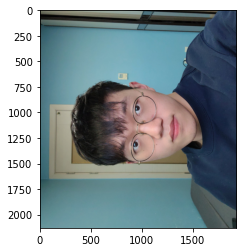

image shape:  (2130, 1920, 3)


In [43]:
new_image_path = os.getenv('HOME')+'/aiffel/Exploration/EX3/image_5.jpg'
new_img_bgr = cv2.imread(new_image_path)    # OpenCV로 이미지를 불러옵니다
new_img_show = new_img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
new_img_rgb = cv2.cvtColor(new_img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(new_img_rgb)
plt.show()
print('image shape: ', new_img_rgb.shape)

In [44]:
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(new_img_rgb, 1)

rectangles[]


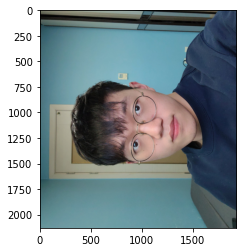

In [45]:
print(dlib_rects)  
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(new_img_show, (l,t), (r,b), (0,255,0), 10, lineType=cv2.LINE_AA)

new_img_show_rgb =  cv2.cvtColor(new_img_show, cv2.COLOR_BGR2RGB)
plt.imshow(new_img_show_rgb)
plt.show() 


#### 발견된 문제점:
멀리서 촬영했을 때 와 비슷하게, 얼굴 검출 단계에서부터 문제가 생겼다. 각도가 지나치게 기울여지면 얼굴을 인식하지 못 하는 문제가 발생하면서 스티커를 적용할 수 없게 된다. 
#### 해결책: 
이 또한 근본적으로는 얼굴 인식 기술의 개선이 있으면 해결될 수 있을 것 같다. 하지만, 이것은 우리가 건들 수 있는 부분이 아니다. 속도만 감안한다면 지금 사용한 dlib의 검출 기술로도 이런 문제를 해결할 수 있다. 이전에 기울여진 사진에서 스티커를 적용해본 케이스를 봤을 때, 대략 45도로 기울여진 얼굴까지는 검출할 수 있는 것 같다. 그렇다면, 이미지에서 얼굴 검출을 하지 못 하는 경우에 최대 3번까지 90도로 사진을 회전하고 얼굴 검출하는 과정을 반복하면, 이런 많이 기울여진 얼굴들도 검출할 수 있을 것이다. 이 방법을 이용하면 각도 때문에 얼굴을 검출하지 못하는 일은 없을 것이다.  
* 앞에서 언급한 것처럼 스티커의 각도도 맞추어야 할 것이다.

### (4) 얼굴 각도 (정면을 보지 않을 때)

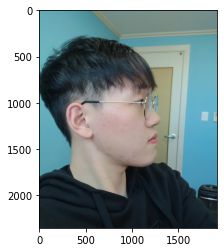

image shape:  (2351, 1920, 3)


In [46]:
new_image_path = os.getenv('HOME')+'/aiffel/Exploration/EX3/image_6.jpg'
new_img_bgr = cv2.imread(new_image_path)    # OpenCV로 이미지를 불러옵니다
new_img_show = new_img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
new_img_rgb = cv2.cvtColor(new_img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(new_img_rgb)
plt.show()
print('image shape: ', new_img_rgb.shape)

In [47]:
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(new_img_rgb, 1)

rectangles[]


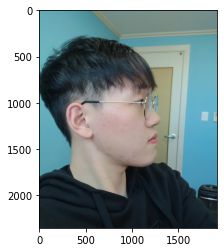

In [48]:
print(dlib_rects)  
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(new_img_show, (l,t), (r,b), (0,255,0), 10, lineType=cv2.LINE_AA)

new_img_show_rgb =  cv2.cvtColor(new_img_show, cv2.COLOR_BGR2RGB)
plt.imshow(new_img_show_rgb)
plt.show() 

#### 발견된 문제점:
얼굴이 정면을 향하고 있지 않을 시, 인식이 되지 않는다. 이는 dlib에서 제공하는 get_frontal_face_detector를 이용했기 때문인데 이 객체는 애초에 얼굴이 나름 정면을 향하고 있다는 전제를 깔고 작동하는 것이 특징이다. 
#### 해결책: 
사용한 얼굴 검출 기술의 근본적인 특성으로 인해 발생한 문제이므로 정면을 바라본 사진을 활용하거나, 이렇게 옆을 바라본 사진도 스티커가 적용되기를 원한다면 아예 다른 얼굴 검출 기술을 사용하는 것 외에는 방법이 없을 것 같다. 

### (5) 밝기에 따른 차이
이미지의 밝기에 따라 스티커앱의 성능차가 발생할 수도 있다
### 밝기가 어두울 때
처음에 사용했던 이미지를 다시 불러온다

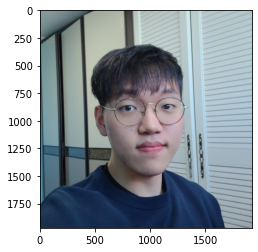

image shape:  (1969, 1920, 3)


In [49]:
new_image_path = os.getenv('HOME')+'/aiffel/Exploration/EX3/image.jpg'
new_img_bgr = cv2.imread(new_image_path)    # OpenCV로 이미지를 불러옵니다
new_img_show = new_img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
new_img_rgb = cv2.cvtColor(new_img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(new_img_rgb)
plt.show()
print('image shape: ', new_img_rgb.shape)

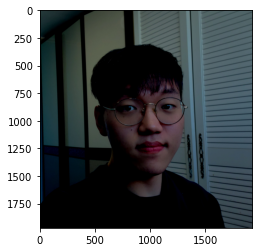

In [50]:
# 100만큼 R,G,B 값에서 빼주면서 사진의 밝기를 그만큼 어둡게 만든다. 
val = 100
array = np.full(new_img_rgb.shape, (val, val, val), dtype=np.uint8)
new_img_rgb_dark = cv2.subtract(new_img_rgb, array)
plt.imshow(new_img_rgb_dark)
plt.show()

In [51]:
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(new_img_rgb_dark, 1)

rectangles[[(510, 511) (1469, 1469)]]


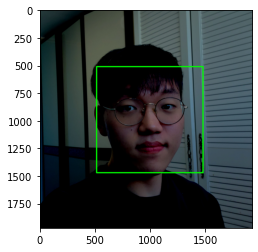

In [52]:
print(dlib_rects)  
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(new_img_rgb_dark, (l,t), (r,b), (0,255,0), 10, lineType=cv2.LINE_AA)

plt.imshow(new_img_rgb_dark)
plt.show() 


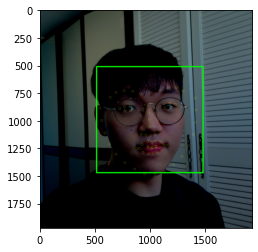

In [55]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(new_img_rgb_dark, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(new_img_rgb_dark, point, 10, (255, 255, 0, -1))

plt.imshow(new_img_rgb_dark)
plt.show()

100만큼 사진의 밝기를 어둡게 했을 때까지는 얼굴이 인식이 되고 landmark가 잘 찾아진다. 아마 HOG이 얼굴 검출하는 방식이 밝기 조절에 불변성이 어느정도 있기 때문일 것이다 (invariance to illumination). 다음과 같이 150만큼으로 사진을 더욱 어둡게 만들면 좀 달라진다.

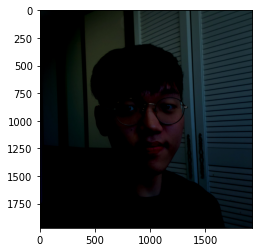

In [56]:
val = 150
array = np.full(new_img_rgb.shape, (val, val, val), dtype=np.uint8)
new_img_rgb_dark = cv2.subtract(new_img_rgb, array)
plt.imshow(new_img_rgb_dark)
plt.show()

In [57]:
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(new_img_rgb_dark, 1)

rectangles[]


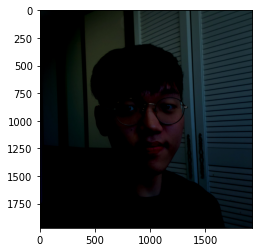

In [58]:
print(dlib_rects)  
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(new_img_rgb_dark, (l,t), (r,b), (0,255,0), 10, lineType=cv2.LINE_AA)

plt.imshow(new_img_rgb_dark)
plt.show() 

이 경우에는 얼굴 검출을 잘 하지 못한다. 이는 아마 각 픽셀의 값을 극단적으로 낮추어 너무 많은 픽셀들이 0의 값이 되어, HOG에서 gradient의 차이를 확인하지 못하는 것으로 예측이 된다.

### 사진의 밝기가 밝을 때

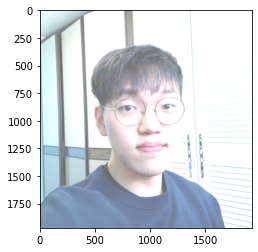

In [59]:
val = 100
array = np.full(new_img_rgb.shape, (val, val, val), dtype=np.uint8)
new_img_rgb_bright = cv2.add(new_img_rgb, array)
plt.imshow(new_img_rgb_bright)
plt.show()

In [60]:
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(new_img_rgb_bright, 1)

rectangles[[(603, 692) (1401, 1491)]]


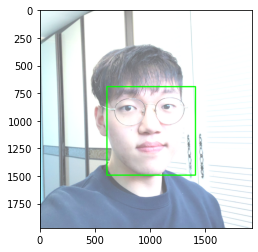

In [61]:
print(dlib_rects)  
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(new_img_rgb_bright, (l,t), (r,b), (0,255,0), 10, lineType=cv2.LINE_AA)

plt.imshow(new_img_rgb_bright)
plt.show() 

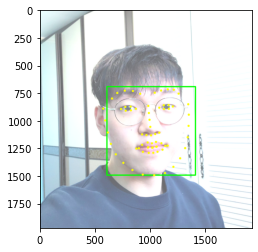

In [62]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(new_img_rgb_bright, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(new_img_rgb_bright, point, 10, (255, 255, 0), -1)

plt.imshow(new_img_rgb_bright)
plt.show()

밝아지는 것도 마찬가지이다. 어느 정도로 밝아져도 얼굴 검출 및 얼굴 landmark이 잘 확인된다. 물론 여기서 값을 150으로 늘리면 또 비슷하게 얼굴 검출에서 실패한다  
#### 결론: 
이 스티커앱은 이미지의 밝기에 너무 크게는 영향을 받지 않는다. 사실 100의 값은 큰 값인데도 정상적으로 작동하는 것을 확인하였는데, 이는 HOG의 원리상 좁은 해당 지역에서의 값의 크기 변화를 확인하여 얼굴을 검출하기 때문이다. 만약 이미지의 일부분만 밝기 조절을 하였다면 문제가 더 생겼을 것이다. 하지만 의도적으로 이미지의 일부를 밝기 조절하거나 이미지의 밝기가 지나치게 어둡거나 밝지 않은 이상 크게 문제가 발생하지 않기 때문에 웬만한 상황에서는 스티커앱이 잘 작동할 수 있을 것이라고 기대할 수 있다. 

### (5) 실행 속도가 중요할까요?
우리가 지금 만든 앱은 정지된 사진 위에 얼굴을 찾아서 스티커를 붙이는 기능을 한다. 이런 경우, 한 번에 하나의 사진을 처리하는 것이기 때문에 빠른 속도로 작업이 완료되기도 하고, 또한 그렇게 빠른 처리를 요하지도 않는다. 만약 스노우처럼 사진을 찍을 때 바로 스티커가 적용되어 실시간으로 확인할 수 있어야되는 상황이라면 말이 조금 다르다. 이 경우에는 카메라의 움직임에 따라 변하는 이미지에 맞추어 바로바로 연산을 행하여 얼굴을 검출하고 스티커를 적용해야 되는데, 이것이 실시간으로 진행되어야 하기 때문에 실행 속도가 굉장히 중요하다. 하지만 지금 만든 어플은 실시간(real-time)으로 사용하지 않기 때문에 속도가 그렇게까지 중요하지는 않다. 

### (6) 스티커앱을 만들 때 정확도가 얼마나 중요할까요?
스티커앱에 있어 정확도는 굉장히 중요하다. 얼굴을 잘 검출하고, 확인한 얼굴에서 올바른 위치에 스티커가 배치되는 것은 어플의 성능의 핵심이다. 얼굴을 제대로 검출하지 못하는 상황은 말할 것도 없고, 얼굴이 인식이 되어도 만약 엉뚱한 곳에 스티커가 배치가 된다면 사용자는 이 앱을 사용하지 않을 것이다. 더구나 요즘은 스티커앱이 워낙 잘 되어 있는 상황이기 때문에 정확도는 스티커앱의 필수 요소라고 할 수 있다. 정확도는 기본으로 깔리고, 그 이후에 어떤 스티커를 제공하는 것이 중요한 것이지, 정확도에 문제가 있다면 사람들이 앱을 사용할 리가 없다.  
  
그렇기 때문에 얼굴을 확실하게 검출하고, 확인한 정보를 바탕으로 스티커를 적절하게 배치할 수 있게 하는 것이 중요하다. 

### 문제점 정리: 
이 스티커앱은 얼굴을 회전하였을 때 회전이 스티커에까지 반영이 되지 않기 때문에 개선이 필요하다.
다른 변수들에 받는 영향:
* 촬영거리: 얼굴이 너무 멀리서 촬영되었을 경우 얼굴 검출에 실패할 수도 있다
* 얼굴의 각도(정면 보고 회전): 얼굴이 너무 많이 기울여지면 얼굴 검출에 실패할 수도 있다. 이는 앱을 개선하면 해결 가능할 수도 있을 것 같다.
* 얼굴의 각도(정면을 보지 않을 때): dlib의 face detector는 기본적으로 정면을 본 것을 전제로 하기 때문에, 그렇지 않을 때는 제대로 검출하지 못한다.
* 이미지의 밝기: 웬만한 상황에서는 정상적으로 작동한다. 하지만 이미지의 일부만 밝기 조절하거나 지나치게 이미지가 어둡거나 밝으면 얼굴 검출에 실패할 수도 있다.
